In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import triton
import original_quant
import gptq_triton
import json
from matplotlib import pyplot as plt
import numpy as np
from gptq_triton.fused_mlp import llama_mlp_fused_4_kernel
from transformers.models.llama.modeling_llama import LlamaMLP
from gptq_triton.quant_linear import matmul4_kernel
from quantize import dumbquant, pack_linear

## Benchmark QuantLinear Kernel
Tests the speed of the Triton, CUDA, and FP16 kernels on 4096x4096, 4096x11008, 11008x4096, and 4096x12288 matrices.

4096->4096, groupsize=-1


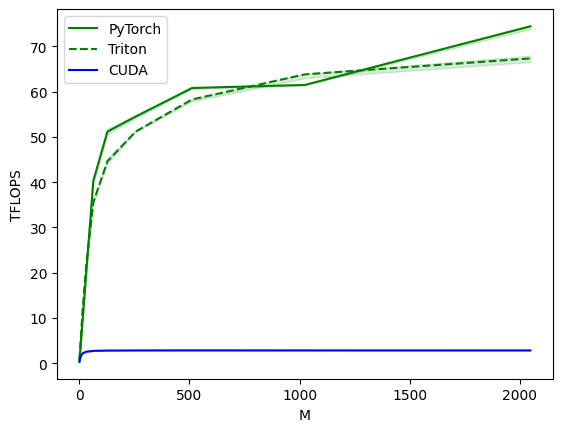

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.668735   0.799220  0.341333
1      2.0   1.260308   1.598439  0.661980
2      4.0   2.473057   3.196878  1.120273
3      8.0   5.041231   6.241524  1.702234
4     16.0   9.892226  12.192744  2.240547
5     32.0  20.164923  21.845333  2.582699
6     64.0  40.329847  35.544948  2.774011
7    128.0  51.150050  44.620254  2.835905
8    256.0  54.471483  51.150050  2.866430
9    512.0  60.787013  58.254220  2.880951
10  1024.0  61.455001  63.791697  2.870722
11  2048.0  74.400071  67.310795  2.866553


4096->4096, groupsize=128


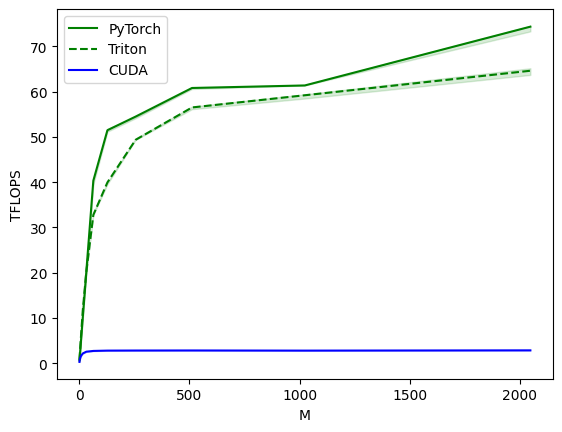

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.655360   0.780190  0.337814
1      2.0   1.260308   1.560381  0.675629
2      4.0   2.520615   3.048186  1.120273
3      8.0   5.041231   5.957818  1.648704
4     16.0  10.082462  11.650844  2.184533
5     32.0  20.164923  20.164923  2.582699
6     64.0  40.329847  32.768000  2.752168
7    128.0  51.463856  39.945753  2.822546
8    256.0  54.471483  49.344753  2.841669
9    512.0  60.787013  56.488944  2.855210
10  1024.0  61.342657  59.178891  2.822072
11  2048.0  74.317678  64.589860  2.880147


4096->11008, groupsize=-1


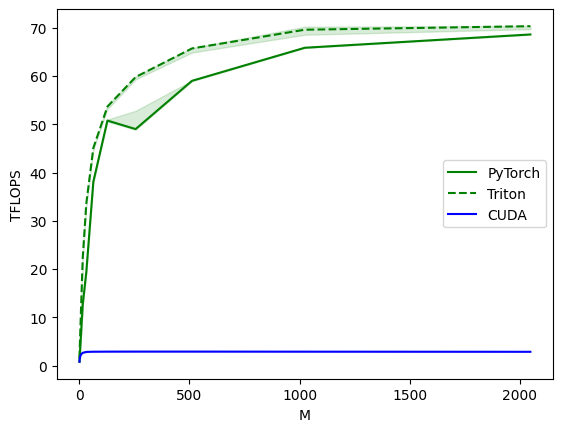

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.752684   1.492610  0.800582
1      2.0   1.601164   2.985220  1.314388
2      4.0   3.202327   5.870933  1.853979
3      8.0   6.346955  11.549377  2.294827
4     16.0  12.693910  22.365460  2.638622
5     32.0  19.301698  33.548191  2.820869
6     64.0  38.081728  45.088766  2.863870
7    128.0  50.775639  53.677105  2.879232
8    256.0  49.009529  59.799429  2.891047
9    512.0  59.016712  65.727069  2.889472
10  1024.0  65.871103  69.608289  2.872628
11  2048.0  68.628262  70.341293  2.846378


4096->11008, groupsize=128


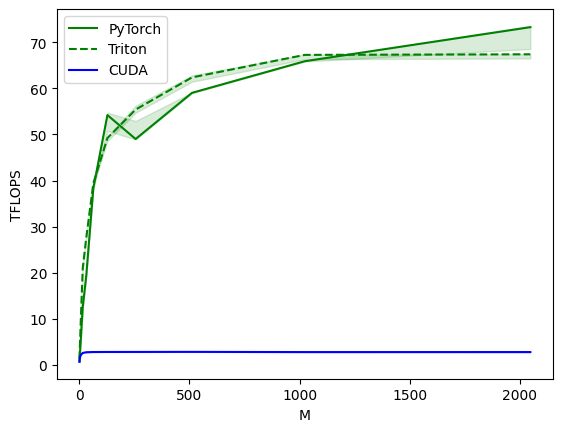

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.752684   1.376000  0.746305
1      2.0   1.586739   2.709662  1.276290
2      4.0   3.173477   5.419323  1.834667
3      8.0   6.290286  10.838646  2.258051
4     16.0  12.580571  21.030209  2.628776
5     32.0  19.434814  27.627922  2.790147
6     64.0  38.340789  39.413259  2.835058
7    128.0  54.193231  49.223546  2.847952
8    256.0  49.009529  55.391605  2.851915
9    512.0  59.016712  62.363443  2.866419
10  1024.0  65.871103  67.246486  2.821663
11  2048.0  73.255509  67.372088  2.824580


11008->4096, groupsize=-1


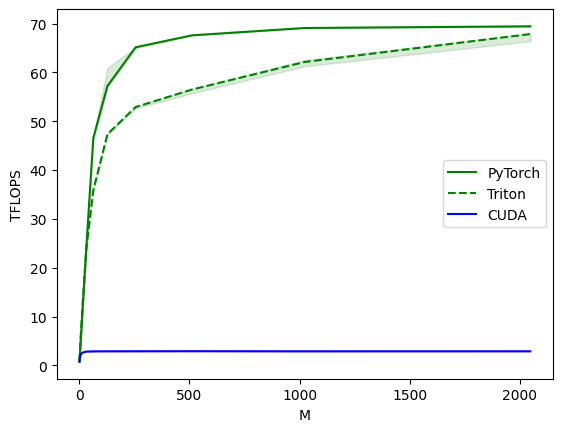

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.721836   0.926989  0.807927
1      2.0   1.505367   1.797225  1.304652
2      4.0   3.010735   3.594449  1.834667
3      8.0   6.073379   6.975366  2.368108
4     16.0  11.940881  13.046518  2.643572
5     32.0  24.085880  23.881762  2.832209
6     64.0  46.579307  35.898700  2.885866
7    128.0  57.219248  47.362153  2.902960
8    256.0  65.157182  52.921088  2.907077
9    512.0  67.599351  56.502214  2.921676
10  1024.0  69.101558  62.148544  2.895596
11  2048.0  69.447467  67.866440  2.903053


11008->4096, groupsize=128


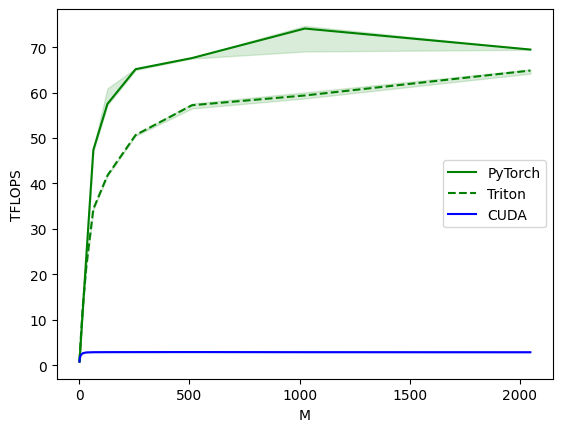

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.721836   0.880640  0.800582
1      2.0   1.505367   1.743842  1.285606
2      4.0   2.985220   3.387077  1.853979
3      8.0   6.021470   6.646340  2.272619
4     16.0  12.042940  12.809309  2.628776
5     32.0  23.881762  21.677292  2.809619
6     64.0  47.362153  34.366440  2.860962
7    128.0  57.511186  41.748861  2.873727
8    256.0  65.157182  50.661536  2.881440
9    512.0  67.599351  57.219248  2.890584
10  1024.0  74.098225  59.366382  2.868516
11  2048.0  69.474219  64.852597  2.853223


4096->12288, groupsize=-1


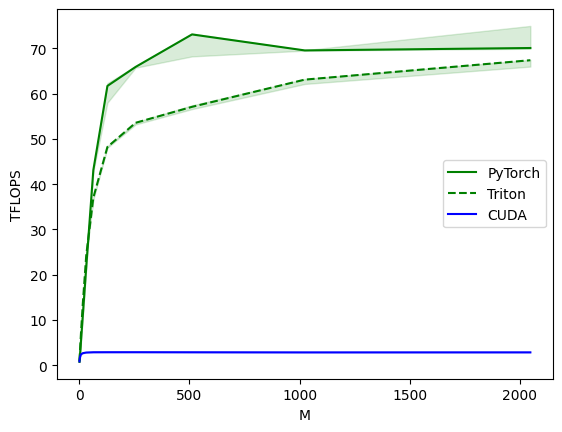

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.768000   0.936229  0.885622
1      2.0   1.374881   1.854792  1.374881
2      4.0   2.711835   3.607486  1.918127
3      8.0   5.423669   7.149382  2.434774
4     16.0  10.847338  13.443282  2.688657
5     32.0  21.845333  24.385490  2.836545
6     64.0  43.092163  37.008565  2.901963
7    128.0  61.680942  48.210389  2.908671
8    256.0  65.879121  53.544306  2.910353
9    512.0  73.050287  57.065359  2.896452
10  1024.0  69.518852  63.072239  2.867941
11  2048.0  70.051006  67.355837  2.877574


4096->12288, groupsize=128


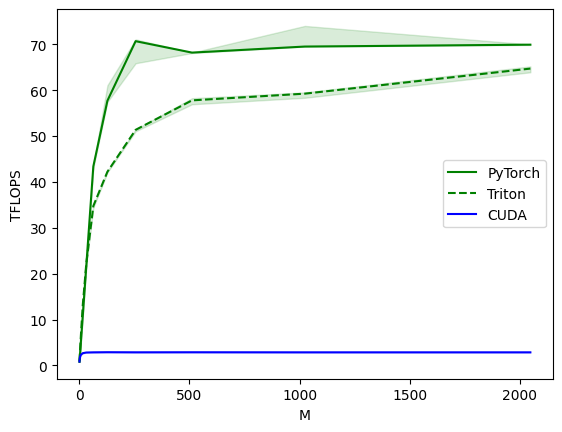

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.768000   0.893673  0.847448
1      2.0   1.365333   1.771243  1.346630
2      4.0   2.730667   3.510857  1.927529
3      8.0   5.461333   6.898526  2.333626
4     16.0  10.773041  13.107200  2.665871
5     32.0  21.694676  22.153013  2.811196
6     64.0  43.389352  34.759426  2.851975
7    128.0  57.719780  42.224537  2.880703
8    256.0  70.690516  51.358824  2.857155
9    512.0  68.200068  57.786048  2.870190
10  1024.0  69.518852  59.248555  2.853430
11  2048.0  69.929347  64.714431  2.853915




In [2]:
matmul4_kernel.record_detailed_timings = True


def benchmarker(M, N, K, groupsize: int, provider):
	layer = nn.Linear(K, N)
	vec = torch.randn(M, K, device='cuda', dtype=torch.float16)

	scales, zeros = dumbquant(layer, 4, groupsize=groupsize)

	cuda_layer = original_quant.QuantLinear(4, groupsize, layer.in_features, layer.out_features)
	cuda_layer.pack(layer, scales.clone(), zeros.clone())

	triton_layer = gptq_triton.QuantLinear(4, groupsize, layer.in_features, layer.out_features, bias=False)
	pack_linear(triton_layer, layer.weight, scales, zeros, None)

	# Convert layer to 16-bit
	layer = layer.half()

	# Move to GPU
	layer = layer.to('cuda')
	cuda_layer = cuda_layer.to('cuda')
	triton_layer = triton_layer.to('cuda')

	if provider == 'torch':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_layer(vec))
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_layer(vec))
	
	perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
	return perf(ms), perf(max_ms), perf(min_ms)


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 4096, -1, provider)

print("4096->4096, groupsize=-1")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 4096, 128, provider)

print("4096->4096, groupsize=128")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 11008, 4096, -1, provider)

print("4096->11008, groupsize=-1")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 11008, 4096, 128, provider)

print("4096->11008, groupsize=128")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 11008, -1, provider)

print("11008->4096, groupsize=-1")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 11008, 128, provider)

print("11008->4096, groupsize=128")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 12288, -1, provider)

print("4096->12288, groupsize=-1")
benchmark.run(show_plots=True, print_data=True)
print()
print()

@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 12288, 128, provider)

print("4096->12288, groupsize=128")
benchmark.run(show_plots=True, print_data=True)
print()
print()

## Benchmark In-Situ
Benchmark Triton and CUDA kernels in the model itself. This is useful because sometimes the Triton kernel is faster in isolation, but performs worse within the context of the model.

In [2]:
# Load the models
cuda_model = original_quant.load_cuda_quant('../weights/HF/llama-7b', '../GPTQ-for-LLaMa/llama7b-4bit-128g-2.pt', 4, -1)
cuda_model.eval()
cuda_model = cuda_model.to('cuda')

model = gptq_triton.load_quant('../weights/llama-7b-4bit', fuse_mlp=False)
model.eval()
model = model.to('cuda')

Loading model ...
Done.
Loading model ...
QuantLinear Warmup: Found 4 unique KN values.
FusedMLP Warmup: Found 0 unique K values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:49<00:00,  4.16s/it]

Done.


Lower is better
groupsize=-1


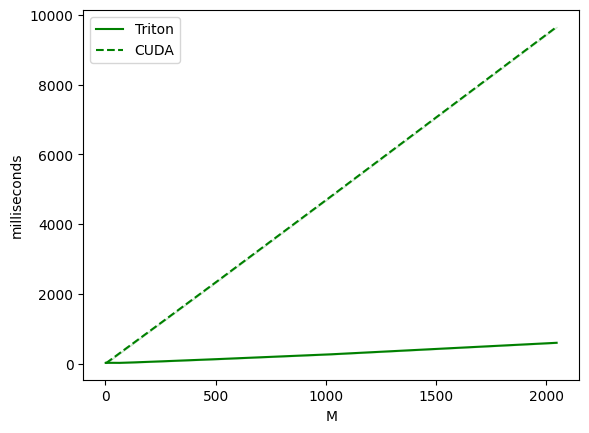

matmul:
         M      Triton         CUDA
0      1.0   24.262657    25.455616
1      2.0   24.892416    28.719105
2      4.0   25.247744    28.100609
3      8.0   26.327553    41.929729
4     16.0   26.308609    78.451714
5     32.0   26.464256   151.428101
6     64.0   25.276928   301.087738
7    128.0   38.426624   597.472290
8    256.0   69.163010  1191.757324
9    512.0  133.680634  2386.569336
10  1024.0  270.583801  4797.017578
11  2048.0  600.460327  9652.925781




In [4]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		position_ids = torch.arange(0, M, dtype=torch.long, device=inputs_embeds.device)
		position_ids = position_ids.unsqueeze(0).view(-1, M)
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				position_ids=position_ids,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'torch':
		raise NotImplementedError
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model), rep=10000)
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['triton', 'cuda'],
		line_names=['Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
print("groupsize=-1")
benchmark.run(show_plots=True, print_data=True)
print()
print()

In [3]:
# Load the models
cuda_model_g128 = original_quant.load_cuda_quant('../weights/HF/llama-7b', '../GPTQ-for-LLaMa/llama7b-cuda-4bit-c4-group128-act-seq.pt', 4, 128)
cuda_model_g128.eval()
cuda_model_g128 = cuda_model_g128.to('cuda')

model_g128 = gptq_triton.load_quant('../weights/llama-7b-triton-4bit-c4-group128-seq', fuse_mlp=False)
model_g128.eval()
model_g128 = model_g128.to('cuda')

Loading model ...
Done.
Loading model ...
QuantLinear Warmup: Found 4 unique KN values.
FusedMLP Warmup: Found 0 unique K values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:46<00:00,  3.87s/it]

Done.


Lower is better
groupsize=128


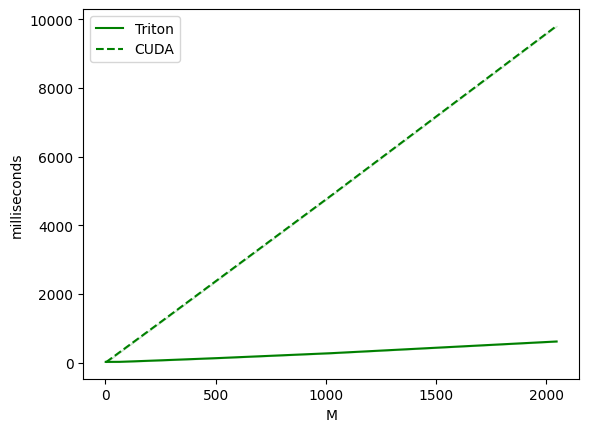

matmul:
         M      Triton         CUDA
0      1.0   25.511936    27.245567
1      2.0   24.679424    25.934849
2      4.0   25.402369    27.659264
3      8.0   26.542080    42.649086
4     16.0   25.625088    79.901695
5     32.0   26.345472   154.585083
6     64.0   27.110399   305.860107
7    128.0   41.837055   607.240234
8    256.0   72.251389  1210.921509
9    512.0  136.818695  2428.449707
10  1024.0  278.980621  4864.481934
11  2048.0  619.520508  9805.682617


In [6]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		position_ids = torch.arange(0, M, dtype=torch.long, device=inputs_embeds.device)
		position_ids = position_ids.unsqueeze(0).view(-1, M)
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				position_ids=position_ids,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'torch':
		raise NotImplementedError
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model_g128), rep=10000)
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model_g128), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['triton', 'cuda'],
		line_names=['Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
print("groupsize=128")
benchmark.run(show_plots=True, print_data=True)

## Visualize `benchmark_generate.py` Results
Run `benchmark_generate.py` and save the results to `results-triton.jsonl` and `results-cuda.jsonl`.  Then run this cell to visualize the results.

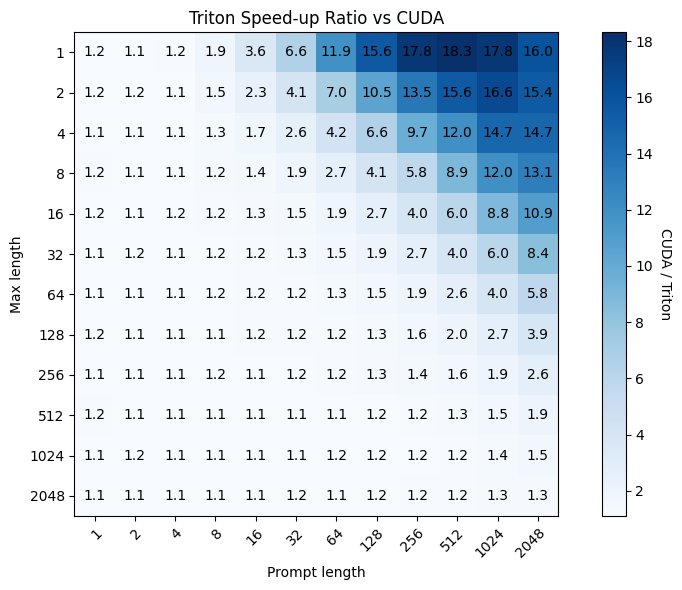

Minimum speed-up: 110.5%
Maximum speed-up: 1831.3%


In [7]:
def read_results(filename):
	with open(filename, 'r') as f:
		results = [json.loads(line) for line in f]
		results = sorted(results, key=lambda x: (x['prompt_length'], x['max_length']))
	return results


# Read the results
triton_results = read_results('results-triton.jsonl')
cuda_results = read_results('results-cuda.jsonl')

# Results as a 2D heatmap
x = sorted(list(set(a['prompt_length'] for a in triton_results)))
y = sorted(list(set(a['max_length'] for a in triton_results)))

z1 = lambda x, y: next(a for a in triton_results if a['prompt_length'] == x and a['max_length'] == y)['average_time']
z2 = lambda x, y: next(a for a in cuda_results if a['prompt_length'] == x and a['max_length'] == y)['average_time']
z = lambda x, y: z2(x, y) / z1(x, y)

# Draw a heatmap with numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow([[z(i, j) for i in x] for j in y], cmap='Blues')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('CUDA / Triton', rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x)), labels=x)
ax.set_yticks(np.arange(len(y)), labels=y)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(x)):
	for j in range(len(y)):
		text = ax.text(i, j, f'{z(x[i], y[j]):.1f}', ha="center", va="center", color="black")

# Label axes
ax.set_xlabel('Prompt length')
ax.set_ylabel('Max length')

ax.set_title("Triton Speed-up Ratio vs CUDA")
f.tight_layout()
plt.show()

# Print some stats
print(f"Minimum speed-up: {(min(z(i, j) for i in x for j in y) * 100):.1f}%")
print(f"Maximum speed-up: {(max(z(i, j) for i in x for j in y) * 100):.1f}%")

## Benchmark Fused MLP Kernel

Lower is better
Groupsize: -1 (no grouping)


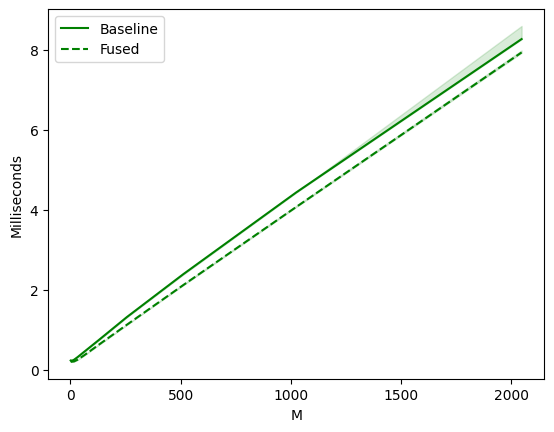

matmul:
         M  Baseline     Fused
0      1.0  0.228352  0.194560
1      2.0  0.220160  0.195584
2      4.0  0.220160  0.197632
3      8.0  0.227328  0.200704
4     16.0  0.247808  0.205824
5     32.0  0.312320  0.247808
6     64.0  0.454656  0.366592
7    128.0  0.738304  0.621568
8    256.0  1.314816  1.123328
9    512.0  2.386944  2.115072
10  1024.0  4.428800  4.065280
11  2048.0  8.266752  7.932928


Groupsize: 128


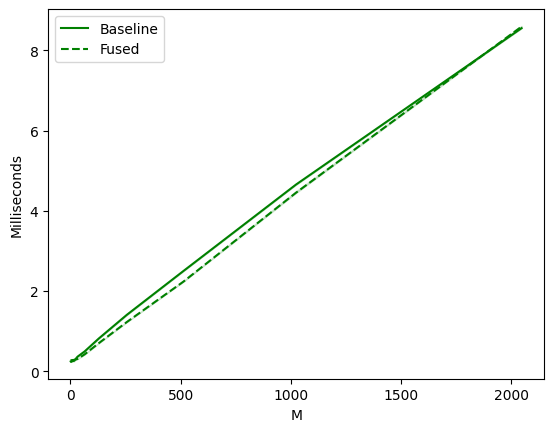

matmul:
         M  Baseline     Fused
0      1.0  0.248832  0.276480
1      2.0  0.238592  0.278528
2      4.0  0.238592  0.279552
3      8.0  0.256000  0.282624
4     16.0  0.262144  0.286720
5     32.0  0.366592  0.310272
6     64.0  0.496640  0.423936
7    128.0  0.817152  0.701440
8    256.0  1.410048  1.230848
9    512.0  2.497536  2.233344
10  1024.0  4.654080  4.451328
11  2048.0  8.549376  8.589312


In [8]:
llama_mlp_fused_4_kernel.record_detailed_timings = True


def benchmarker(M, K, groupsize, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)
	layer = LlamaMLP(4096, 11008, 'silu')
	layer = layer.half()

	# Quantize linear layers
	for name, m in layer.named_modules():
		if not isinstance(m, nn.Linear):
			continue

		scales, zeros = dumbquant(m, 4, groupsize=groupsize)

		triton_layer = gptq_triton.QuantLinear(4, groupsize, m.in_features, m.out_features, bias=False)
		pack_linear(triton_layer, m.weight, scales, zeros, None)

		setattr(layer, name, triton_layer)

	# Fuse
	fused_layer = gptq_triton.make_fused_mlp(layer)
	assert isinstance(fused_layer, gptq_triton.QuantLlamaMLP)

	# Move to CUDA
	layer.to('cuda')
	fused_layer.to('cuda')

	if provider == 'baseline':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: fused_layer(vec))
	
	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['baseline', 'fused'],
		line_names=['Baseline', 'Fused'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='Milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, -1, provider)

print("Lower is better")
print("Groupsize: -1 (no grouping)")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['baseline', 'fused'],
		line_names=['Baseline', 'Fused'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='Milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 128, provider)

print("Groupsize: 128")
benchmark.run(show_plots=True, print_data=True)

## Benchmark Fused MLP In-Situ

In [4]:
# Load the models
fused_model = gptq_triton.load_quant('../weights/llama-7b-4bit', fuse_mlp=True)
fused_model.eval()
fused_model = fused_model.to('cuda')

Loading model ...
QuantLinear Warmup: Found 3 unique KN values.
FusedMLP Warmup: Found 1 unique K values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:18<00:00,  1.57s/it]

Done.


Lower is better
Groupsize: -1 (no grouping)


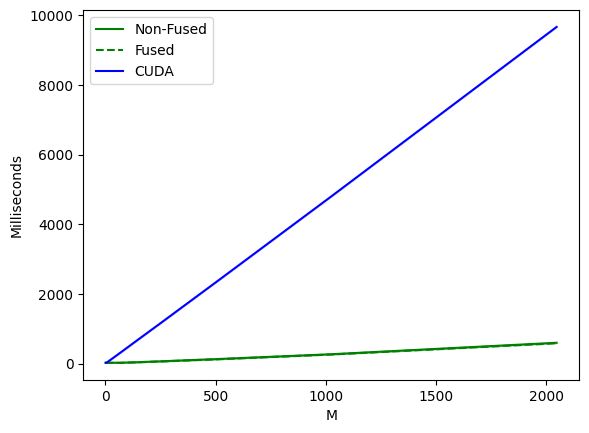

matmul:
         M   Non-Fused       Fused         CUDA
0      1.0   25.006081   21.793793    26.510849
1      2.0   26.047487   23.169024    26.668545
2      4.0   26.575872   24.653824    27.815424
3      8.0   24.983553   23.940096    42.163712
4     16.0   25.568256   23.700993    79.110146
5     32.0   27.261951   24.293377   152.717819
6     64.0   25.638912   24.064512   299.766785
7    128.0   38.503426   36.505600   598.143982
8    256.0   69.243393   65.353729  1191.380981
9    512.0  133.709824  127.573502  2388.249512
10  1024.0  270.673920  263.683075  4797.833008
11  2048.0  600.557617  586.769409  9668.835938


In [10]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		position_ids = torch.arange(0, M, dtype=torch.long, device=inputs_embeds.device)
		position_ids = position_ids.unsqueeze(0).view(-1, M)
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				position_ids=position_ids,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'non-fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model), rep=10000)
	elif provider == 'fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, fused_model), rep=10000)
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['non-fused', 'fused', 'cuda'],
		line_names=['Non-Fused', 'Fused', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='Milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
print("Groupsize: -1 (no grouping)")
benchmark.run(show_plots=True, print_data=True)

In [5]:
# Clear some memory
del fused_model
del cuda_model
del model
torch.cuda.empty_cache()

# Load the models
fused_model_g128 = gptq_triton.load_quant('../weights/llama-7b-triton-4bit-c4-group128-seq', fuse_mlp=True)
fused_model_g128.eval()
fused_model_g128 = fused_model_g128.to('cuda')

Loading model ...
QuantLinear Warmup: Found 3 unique KN values.
FusedMLP Warmup: Found 1 unique K values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:20<00:00,  1.69s/it]

Done.


Lower is better


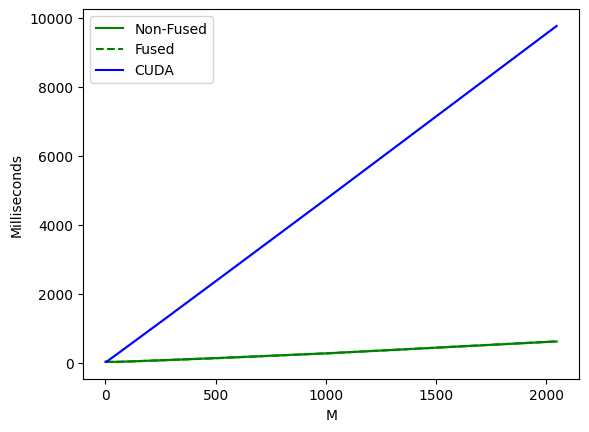

matmul:
         M   Non-Fused       Fused         CUDA
0      1.0   25.511936   23.188480    26.312191
1      2.0   24.969215   23.390720    26.033152
2      4.0   25.173504   24.927233    29.101055
3      8.0   27.027456   24.655872    42.444290
4     16.0   25.086975   23.070208    79.542274
5     32.0   24.754688   24.315903   154.684418
6     64.0   27.535360   25.948160   303.954437
7    128.0   41.982975   40.179199   604.521484
8    256.0   72.478722   69.636093  1205.474854
9    512.0  136.862717  133.014526  2417.442871
10  1024.0  278.867981  277.067780  4851.676758
11  2048.0  616.772583  619.146729  9758.545898




In [6]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		position_ids = torch.arange(0, M, dtype=torch.long, device=inputs_embeds.device)
		position_ids = position_ids.unsqueeze(0).view(-1, M)
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				position_ids=position_ids,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'non-fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model_g128), rep=10000)
	elif provider == 'fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, fused_model_g128), rep=10000)
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model_g128), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['non-fused', 'fused', 'cuda'],
		line_names=['Non-Fused', 'Fused', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='Milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
benchmark.run(show_plots=True, print_data=True)
print()
print()

## Detailed Timings
By enabling `record_detailed_timings` on a kernel's autotune, we can get a detailed breakdown of how each configuration performs.  My methodology is to enable all configurations, run the benchmark, and then use the information printed here to select the smallest set of configurations that are useful.

In [7]:
def config_to_str(config):
	kwargs = ', '.join(f"'{k}': {v}" for k,v in config.kwargs.items())
	return f"{{{kwargs}}}, num_stages={config.num_stages}, num_warps={config.num_warps}"

def print_detailed_timings(kernel):
	for k, timing in kernel.detailed_timings.items():
		# Sort timing
		timing = sorted(timing.items(), key=lambda x: x[1][0])
		print(f'{k}:')

		best = timing[0][1][0]

		for config, (ms, min_ms, max_ms) in timing[:4]:
			ratio = ms / best
			if ratio > 1.05:
				break
			print(f'  {config_to_str(config)}: {ratio:.2f}x')
		print()


print("Detailed timings for matmul4_kernel:")
print_detailed_timings(matmul4_kernel)
print()
print("----------------------------------------")
print()

print("Detailed timings for llama_mlp_fused_4_kernel:")
print_detailed_timings(llama_mlp_fused_4_kernel)

Detailed timings for matmul4_kernel:
(1, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(2, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(4, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(8, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(16, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(32, 4096, 4096):
  {'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(64, 4096, 4096):
  {'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(128, 4096, 409